# Fish Life Prediction

Predicting if fish can life in stated environment.

# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

#Disable Warning
import warnings
warnings.filterwarnings('ignore')

# Outlier Handling
from feature_engine.outliers import Winsorizer

# Stats Analysis
from scipy.stats import f_oneway

# Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Machine Learning Pipeline
from sklearn.pipeline import Pipeline

# Machine Learning Evaluation
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Data Loading

In [2]:
database = pd.read_csv('Realtime-env2.csv')
database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74796 entries, 0 to 74795
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             74758 non-null  object 
 1   Time             74707 non-null  object 
 2   NITRATE(PPM)     74758 non-null  float64
 3   PH               74758 non-null  float64
 4   AMMONIA(mg/l)    74758 non-null  float64
 5   TEMP             74758 non-null  float64
 6   DO               74758 non-null  float64
 7   TURBIDITY        74758 non-null  float64
 8   MANGANESE(mg/l)  74758 non-null  float64
 9   pressure         74758 non-null  float64
 10  tempC            74758 non-null  float64
 11  humidity         74758 non-null  float64
 12  windspeedKmph    74758 non-null  float64
 13  label            74758 non-null  float64
dtypes: float64(12), object(2)
memory usage: 8.0+ MB


In [3]:
database.head()

,Date,Time,NITRATE(PPM),PH,AMMONIA(mg/l),TEMP,DO,TURBIDITY,MANGANESE(mg/l),pressure,tempC,humidity,windspeedKmph,label
0,01-02-2022,08:00:00,112.1,7.7,0.002,24.35,1.9,21.3,2.01,1012.0,27.0,21.0,4.0,0.0
1,01-02-2022,08:20:00,119.8,7.6,0.088,24.30,0.8,31.0,1.00,1012.0,30.0,19.0,4.0,0.0
2,01-02-2022,08:40:00,127.4,8.5,0.029,24.28,2.6,27.4,2.45,1012.0,33.0,16.0,4.0,0.0
3,01-02-2022,09:00:00,105.0,7.5,0.060,24.25,2.9,21.9,1.83,1011.0,37.0,13.0,4.0,0.0
4,01-02-2022,09:20:00,121.1,7.4,0.001,24.10,1.3,22.7,1.69,1010.0,37.0,12.0,4.0,0.0


In [4]:
database.tail()

,Date,Time,NITRATE(PPM),PH,AMMONIA(mg/l),TEMP,DO,TURBIDITY,MANGANESE(mg/l),pressure,tempC,humidity,windspeedKmph,label
74791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Insight: Data Has 13 column with 2 object type and 11 numeric type.

### Domain Knowledge

In this Dataset, Date and Time doesn't have use because we using classification model rather than time series, so it's save to drop it.

In [5]:
# Drop Date and Time Column
database.drop(columns=['Date','Time'],inplace=True)
database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74796 entries, 0 to 74795
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   NITRATE(PPM)     74758 non-null  float64
 1   PH               74758 non-null  float64
 2   AMMONIA(mg/l)    74758 non-null  float64
 3   TEMP             74758 non-null  float64
 4   DO               74758 non-null  float64
 5   TURBIDITY        74758 non-null  float64
 6   MANGANESE(mg/l)  74758 non-null  float64
 7   pressure         74758 non-null  float64
 8   tempC            74758 non-null  float64
 9   humidity         74758 non-null  float64
 10  windspeedKmph    74758 non-null  float64
 11  label            74758 non-null  float64
dtypes: float64(12)
memory usage: 6.8 MB


# Exploration Data Analysis

### See Duplicate Data

In [6]:
database.duplicated().sum()

37

Insight: There's No Duplicated Data

### See Cardinality of Data

In [7]:
database.nunique()

NITRATE(PPM)       53330
PH                 46273
AMMONIA(mg/l)      22217
TEMP               51787
DO                 53697
TURBIDITY          49789
MANGANESE(mg/l)    44486
pressure              30
tempC                 42
humidity              98
windspeedKmph         37
label                  2
dtype: int64

<Axes: >

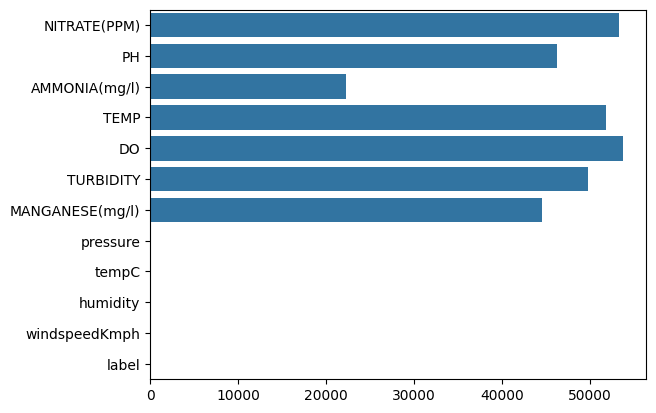

In [8]:
# Visualization
sns.barplot(database.nunique(),orient='h')

Insight: All columns has large unique data with cardinality > 15

### See Empty Data

In [9]:
database.isnull().sum()

NITRATE(PPM)       38
PH                 38
AMMONIA(mg/l)      38
TEMP               38
DO                 38
TURBIDITY          38
MANGANESE(mg/l)    38
pressure           38
tempC              38
humidity           38
windspeedKmph      38
label              38
dtype: int64

<Axes: >

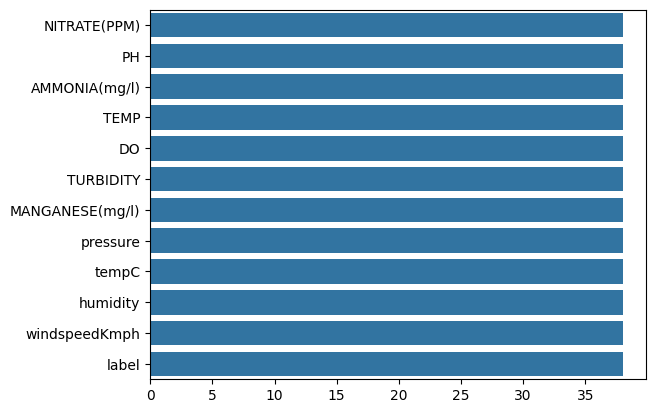

In [10]:
#Visualization
sns.barplot(orient='h',data=database.isnull().sum())

Insight: All Column Have Empty value/Null Value with same size of empty data.

### See Correlation Each of Column From Empty Data

<Axes: >

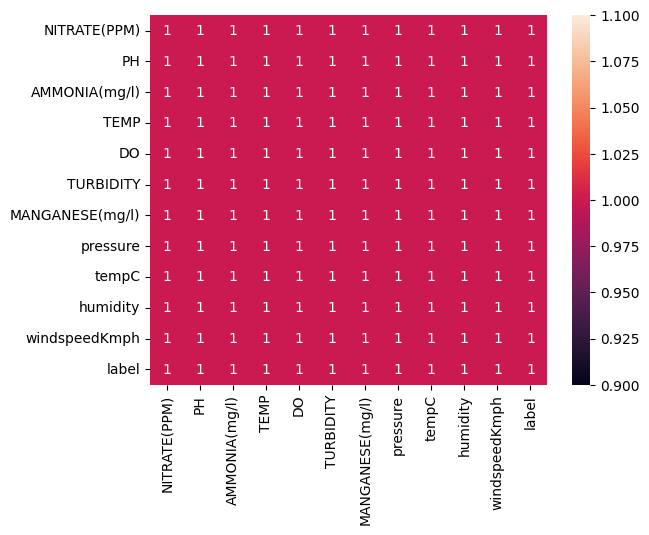

In [11]:
sns.heatmap(data=database.isnull().corr(method='kendall'),annot=True)

Insight: All empty data From Column have strong correlation each other.

### See Occurence Which Data that has Null Value

In [12]:
# Assuming 'database' is your DataFrame
# Use .isnull() to create a DataFrame of True/False values where True indicates NaN
nan_locations = database.isnull()

# Use .any(axis=1) to check if any NaN value is present in each row
rows_with_null = nan_locations.any(axis=1)

# Display the rows with null values
rows_with_null_df = database[rows_with_null]
print(rows_with_null_df[:10])

       NITRATE(PPM)  PH  AMMONIA(mg/l)  TEMP  DO  TURBIDITY  MANGANESE(mg/l)  \
74758           NaN NaN            NaN   NaN NaN        NaN              NaN   
74759           NaN NaN            NaN   NaN NaN        NaN              NaN   
74760           NaN NaN            NaN   NaN NaN        NaN              NaN   
74761           NaN NaN            NaN   NaN NaN        NaN              NaN   
74762           NaN NaN            NaN   NaN NaN        NaN              NaN   
74763           NaN NaN            NaN   NaN NaN        NaN              NaN   
74764           NaN NaN            NaN   NaN NaN        NaN              NaN   
74765           NaN NaN            NaN   NaN NaN        NaN              NaN   
74766           NaN NaN            NaN   NaN NaN        NaN              NaN   
74767           NaN NaN            NaN   NaN NaN        NaN              NaN   

       pressure  tempC  humidity  windspeedKmph  label  
74758       NaN    NaN       NaN            NaN    NaN  
74759

Insight: NaN data have same occurence on same row on all Column, so it's save to drop it latter on Feature Engineering.

### See the Means Of Data

In [13]:
database.mean()

NITRATE(PPM)         38.699076
PH                    6.542758
AMMONIA(mg/l)         0.096194
TEMP                 27.226410
DO                   10.762849
TURBIDITY            31.594800
MANGANESE(mg/l)       0.981192
pressure           1008.148051
tempC                27.693250
humidity             46.384681
windspeedKmph         8.761310
label                 0.732310
dtype: float64

<Axes: >

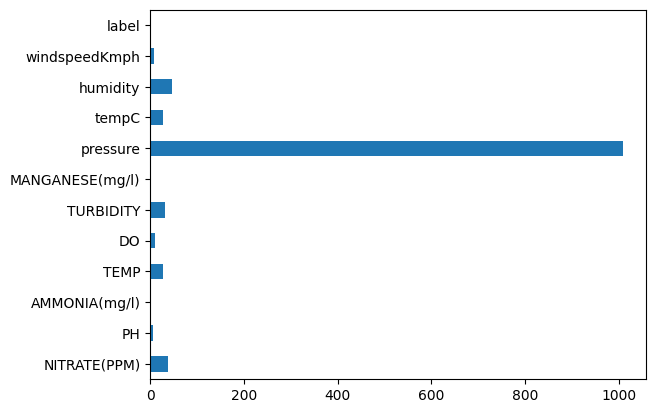

In [14]:
#Visualization
database.mean().plot(kind='barh')

### See Skewness of Data

In [15]:
database.skew()

NITRATE(PPM)       1.554859
PH                 0.379243
AMMONIA(mg/l)      5.215232
TEMP               0.591164
DO                 0.602759
TURBIDITY          1.013689
MANGANESE(mg/l)    1.776782
pressure          -0.009938
tempC              0.221178
humidity           0.381365
windspeedKmph      0.891597
label             -1.049402
dtype: float64

<Axes: >

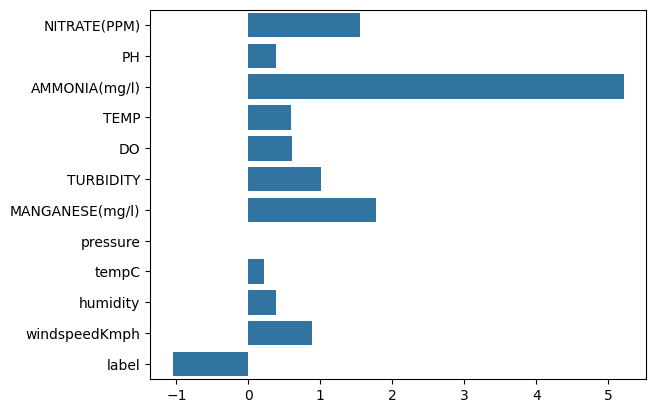

In [16]:
# Visualization
sns.barplot(database.skew(),orient='h')

Insight: PH tempC and humidity has Normal Distribution of Data, while other than that has Skewwed Distribution of Data.

### See Kurtosis of Data

In [17]:
database.kurtosis()

NITRATE(PPM)        1.486333
PH                 -0.692156
AMMONIA(mg/l)      32.704746
TEMP                0.385738
DO                 -0.504282
TURBIDITY           1.138160
MANGANESE(mg/l)     2.161953
pressure           -1.045701
tempC              -0.332113
humidity           -1.061804
windspeedKmph       1.204482
label              -0.898779
dtype: float64

<Axes: >

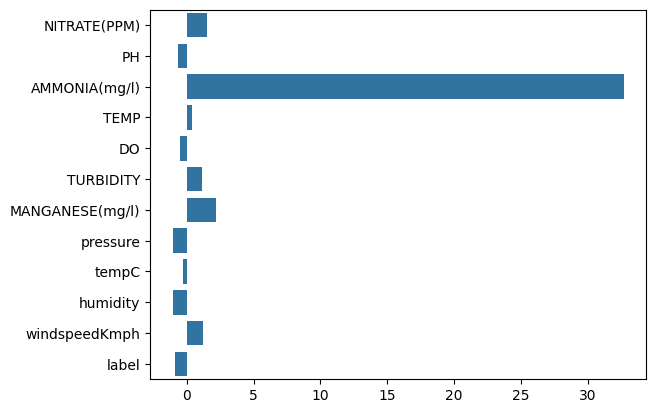

In [18]:
# Visualization
sns.barplot(database.kurtosis(),orient='h')

Insight: Majority of data has large outlier with kurtosis not equal to 0.

### See Correlation of Each Data

In [19]:
f_oneway(database.query('label == 0'),database.query('label == 1')).pvalue < 0.05

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

<Axes: >

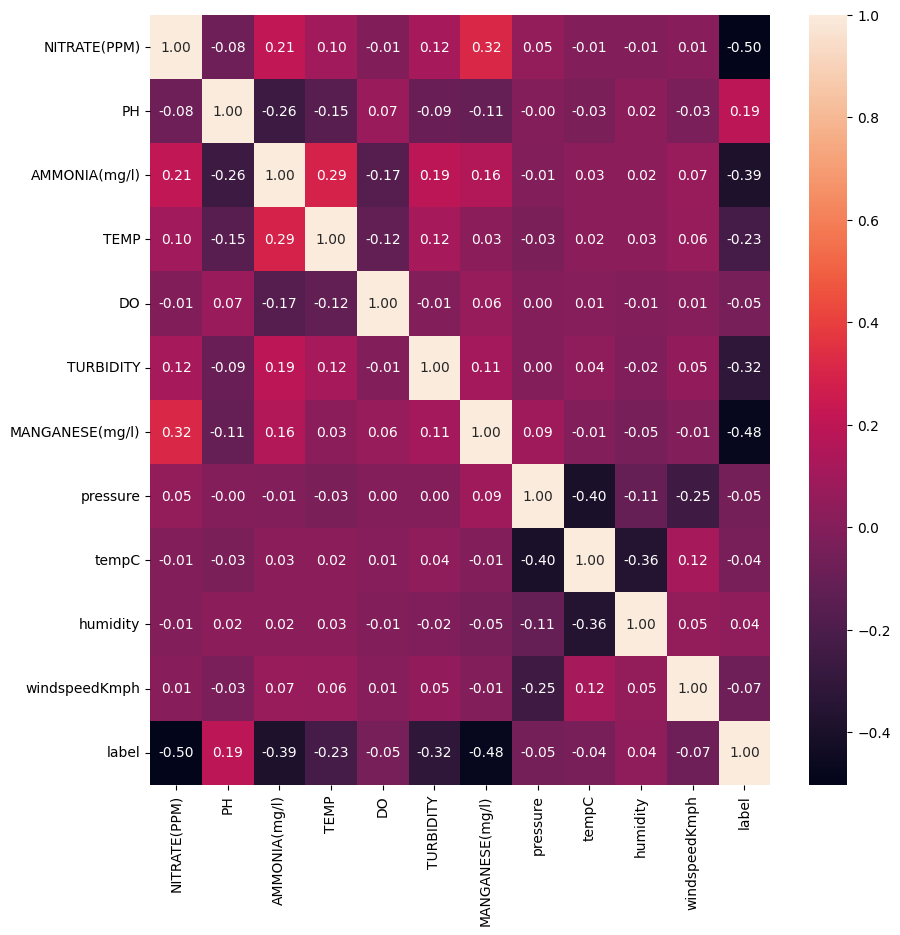

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(database.corr(method='kendall'),annot=True,fmt='.2f')

Insight: NITRATE(PPM), PH, AMMONIA(mg/l), TEMP, TURBIDITY, MANGANESE(mg/l) are column that have high correlation towards data with correlation > 10%.

In [21]:
feature = ['NITRATE(PPM)', 'PH', 'AMMONIA(mg/l)', 'TEMP', 'TURBIDITY', 'MANGANESE(mg/l)']

### See Correlation of Each Feature

<Axes: >

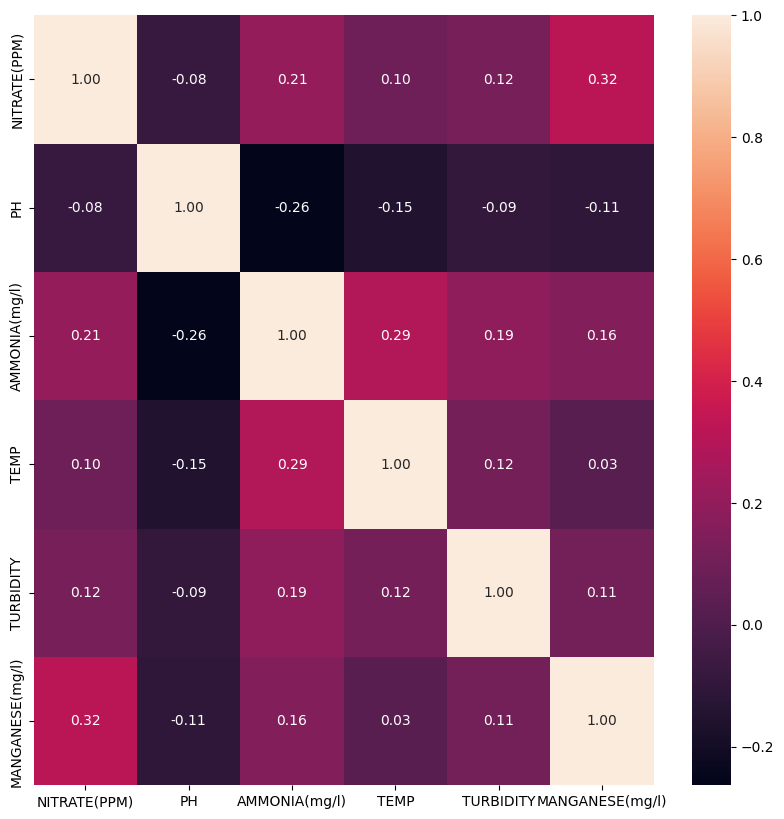

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(database[feature].corr(method='kendall'),annot=True,fmt='.2f')

Insight:
- TEMP and MANGANESE(mg/l) have small correlation of each other.
- TURBIDITY and PH have small correlation of each other.
- PH and Nitrate have small correlation of each other.

### See Correlation From Feature to Target

<Axes: >

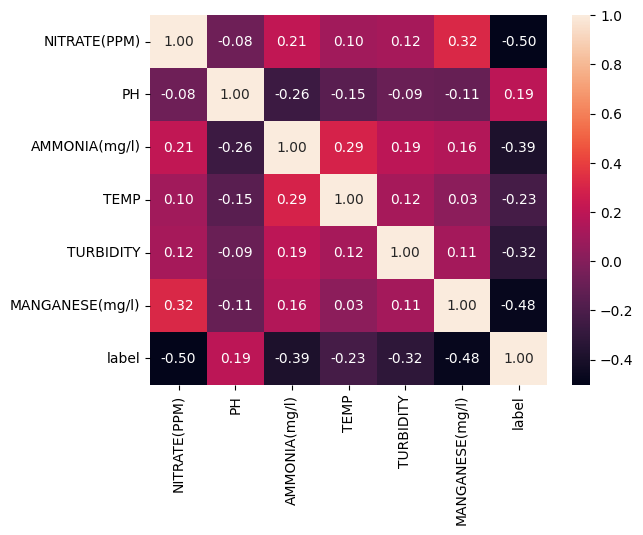

In [23]:
sns.heatmap(database[feature+['label']].corr(method='kendall'),annot=True,fmt='.2f')

Insight: 
Correlation difference between feature that has correlation with each other:
- TEMP < MANGANESE(mg/l)
- TURBIDITY > PH
- PH < NITRATE(PPM)

By this, the feature that being used based of how large the correlation to target are MANGANESE(mg/l), TURBIDITY, NITRATE(PPM)

In [24]:
feature = ['MANGANESE(mg/l)', 'TURBIDITY', 'NITRATE(PPM)']

### See Skewness of Feature

In [25]:
database[feature].skew()

MANGANESE(mg/l)    1.776782
TURBIDITY          1.013689
NITRATE(PPM)       1.554859
dtype: float64

<Axes: >

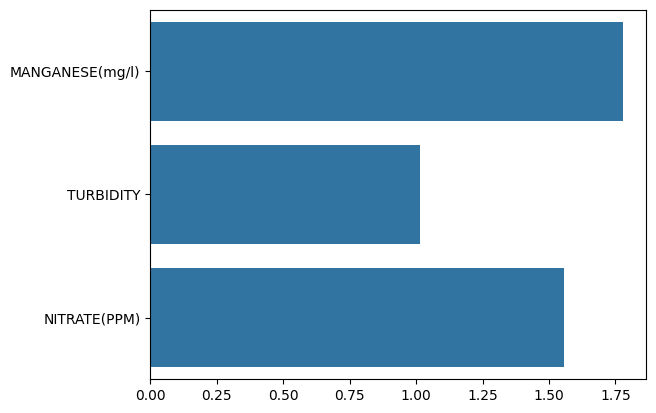

In [26]:
# Visualization
sns.barplot(database[feature].skew(),orient='h')

Insight: Feature has Skewwed distribution with skewness > 0.5

### See Kurtosis of Feature

In [27]:
database[feature].kurtosis()

MANGANESE(mg/l)    2.161953
TURBIDITY          1.138160
NITRATE(PPM)       1.486333
dtype: float64

<Axes: >

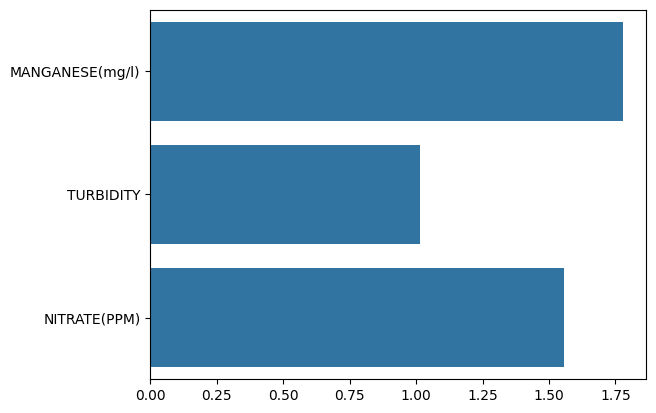

In [28]:
#Visualization
sns.barplot(database[feature].skew(),orient='h')

Insight: Feature has large outlier with kurtosis >= 1

### See Cardinality of Feature

In [29]:
database[feature].nunique()

MANGANESE(mg/l)    44486
TURBIDITY          49789
NITRATE(PPM)       53330
dtype: int64

<Axes: >

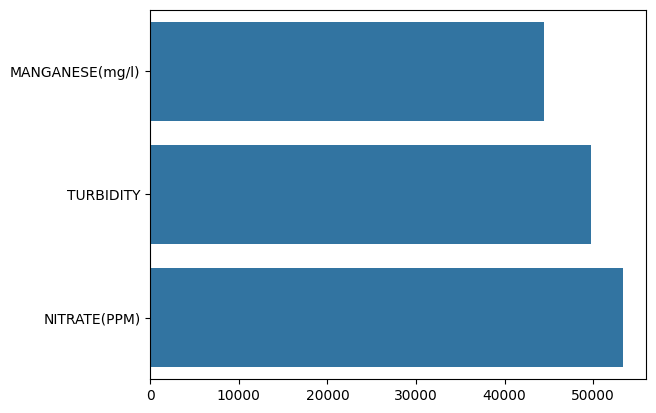

In [30]:
#Visualization
sns.barplot(database[feature].nunique(),orient='h')

Insight: Feature have High Cardinality, meaning Feature are Numeric Data

## EDA Conclusion
- All Data has high cardinality except label, **So label are categorical and outlier doesn't need to be handled**
- All Data have number type, **so all feature will be scalled**
- The feature are **MANGANESE, TURBIDITY, NITRATE(PPM)** columns
- The target are **label** column
- Feature Have High Cardinality, **so feature are numeric**
- Feature has Large Outlier, **so outlier need to be handled** 
- Feature has skewwed Data, **So Scaling technique that be used are MinMaxScaller and Outlier Handling that'll be used are IQR capping method**
- Empty Data are in same row, **so it's safe to drop the row that has Empty Data**

# Feature Engineering

### Handling Missing Value

In [31]:
database.dropna(inplace=True)
database.isnull().sum()

NITRATE(PPM)       0
PH                 0
AMMONIA(mg/l)      0
TEMP               0
DO                 0
TURBIDITY          0
MANGANESE(mg/l)    0
pressure           0
tempC              0
humidity           0
windspeedKmph      0
label              0
dtype: int64

Insight: Missing Value Has been dropped

### Data Splitting

In [32]:
X,y = database.drop(columns=['label']), database['label']
[X.shape, y.shape]

[(74758, 11), (74758,)]

Insight: Data Has Been Splitted with X as feature and y as Target.

### Feature Selection

In [33]:
X=X[feature]
X.columns

Index(['MANGANESE(mg/l)', 'TURBIDITY', 'NITRATE(PPM)'], dtype='object')

### Train Test Split

In [34]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

Insight: Data Has been splitted to train and test

### Handling Outlier

In [35]:
# Handling Outlier
win_skew = Winsorizer(capping_method='iqr',fold=1.5,tail='both',variables=X.columns.to_list())

win_skew.fit(X_train)
X_train = win_skew.transform(X_train)
X_test = win_skew.transform(X_test)

Insight: Outlier has been handled

# Model Definition

In [36]:
# Model Definition
model_base = {
    'logic':LogisticRegression(),    
    'knn':KNeighborsClassifier(),
    'svc':SVC(),
    'decision':DecisionTreeClassifier()
}
model={}
for key,modeling in model_base.items():
    model[key]=Pipeline([('scaler',MinMaxScaler()),('model',modeling)])
model

{'logic': Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())]),
 'knn': Pipeline(steps=[('scaler', MinMaxScaler()), ('model', KNeighborsClassifier())]),
 'svc': Pipeline(steps=[('scaler', MinMaxScaler()), ('model', SVC())]),
 'decision': Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('model', DecisionTreeClassifier())])}

Insight: Model Has Been Defined

In [37]:
# Hyperparameter definition
hyperparam = {
    'logic': {
        'model__C': [0.01, 0.1, 1.0],
        'model__penalty': ['l1', 'l2', 'elasticnet', None],
        'model__solver': ['liblinear', 'lbfgs', 'sag','newton-cg'],
        'model__max_iter': [100, 200]
    },
    'knn': {
        'model__n_neighbors': [3, 5, 7, 9, 11],
        'model__p': [1, 2],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree']
    },
    'svc': {
        'model__C': [0.01, 0.1, 1.0],
        'model__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    },
    'decision':{
        'model__criterion': ['gini', 'entropy'],
        'model__splitter': ['best', 'random'],
        'model__max_depth': [None, 10, 20, 30],  # Adjust based on your dataset and complexity requirements
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['auto', 'sqrt', 'log2', None]
    }
}

Insight: Hyperparameter Has Been Defined

# Model Training

### Without Tunning

In [38]:
### Without Tunning
wot_model = {}
for key, modeling in model.items():
    wot_model[key] = modeling.fit(X_train,y_train)
wot_model

{'logic': Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())]),
 'knn': Pipeline(steps=[('scaler', MinMaxScaler()), ('model', KNeighborsClassifier())]),
 'svc': Pipeline(steps=[('scaler', MinMaxScaler()), ('model', SVC())]),
 'decision': Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('model', DecisionTreeClassifier())])}

Insight: Model Has Been Train without tunning.

### With Tunning

In [39]:
### With Tunning
wt_model = {}
for key, modeling in model.items():
    try:
        print(key)
        grid = RandomizedSearchCV(modeling,hyperparam[key],cv=5,n_jobs=-1,random_state=0)
        grid.fit(X_train,y_train)
        wt_model[key] = grid.best_estimator_
    except:
        grid = RandomizedSearchCV(modeling,hyperparam[key],cv=5,n_jobs=-1,random_state=0)
        grid.fit(X_train,y_train)
        wt_model[key] = grid.best_estimator_
wt_model

logic
knn
svc
decision


{'logic': Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('model', LogisticRegression(penalty=None, solver='sag'))]),
 'knn': Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('model',
                  KNeighborsClassifier(algorithm='kd_tree', n_neighbors=11,
                                       p=1))]),
 'svc': Pipeline(steps=[('scaler', MinMaxScaler()), ('model', SVC())]),
 'decision': Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('model',
                  DecisionTreeClassifier(criterion='entropy', max_depth=10))])}

Insight: Model Has Been Trained with tunning

# Model Evaluation

In [40]:
def right_percent(feature,target,model_test):
    result={}
    if len(model_test)>1:
        for key,modeling in model_test.items():
            predict = modeling.predict(feature)
            result[key] = f'{round((target == predict).mean()*100,2)}%'
            print(f'{key} : {result[key]}')
    else:
        predict = modeling.predict(feature)
        result = f'{round((target == predict).mean()*100,2)}%'
        print(f'model: {result}')
    return result    

def full_eva(feature,target,model_train):
    if len(model_train)>1:
        for key, modeling in model_train.items():
            predict = modeling.predict(feature)
            print("="*20,key,"="*20)
            print(classification_report(target,predict))
    else:
        predict = model_train.predict(feature)
        print("="*20,key,"="*20)
        print(classification_report(target,predict))

def conf_matrix_show(feature,target,model_train):
    if len(model_train)>1:
        for key, modeling in model_train.items():
            prediction = modeling.predict(feature)
            cm = confusion_matrix(target,prediction)
            disp = ConfusionMatrixDisplay(cm)
            disp.plot()
            plt.title(key)
            plt.show()
    else:
        prediction = model_train.predict(feature)
        cm = confusion_matrix(target,prediction)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.title(key)
        plt.show()

### Match Percentage

#### Without Tunning

In [41]:
print('='*20,'Train','='*20)
right_percent(X_train,y_train,wot_model)
print('='*20,'Test','='*20)
right_percent(X_test,y_test,wot_model)


==================== Train ====================
logic : 94.67%
knn : 96.83%
svc : 95.77%
decision : 99.91%
==================== Test ====================
logic : 94.6%
knn : 95.52%
svc : 95.53%
decision : 95.22%


{'logic': '94.6%', 'knn': '95.52%', 'svc': '95.53%', 'decision': '95.22%'}

Insight: 
- All model have high percentage, but decision tree model are overfit when predict train data.
- Highest and Consistent percentage on train and test are SVC model with match percentage 98% on train and test

#### With Tunning

In [42]:
print('='*20,'Train','='*20)
right_percent(X_train,y_train,wt_model)
print('='*20,'Test','='*20)
right_percent(X_test,y_test,wt_model)
# print('='*20,'Real Data Test','='*20)
# right_percent(X,y,wt_model)

==================== Train ====================
logic : 94.67%
knn : 96.46%
svc : 95.77%
decision : 97.14%
==================== Test ====================
logic : 94.62%
knn : 95.89%
svc : 95.53%
decision : 95.78%


{'logic': '94.62%', 'knn': '95.89%', 'svc': '95.53%', 'decision': '95.78%'}

Insight: 
- All model have high percentage
- Highest and Consistent percentage on train and test are SVC model with match percentage 98% on train and test

### Classification Report

#### Without Tunning

In [43]:
print('='*20,'Train','='*20)
full_eva(X_train,y_train,wot_model)
print('='*20,'Test','='*20)
full_eva(X_test,y_test,wot_model)

==================== Train ====================
==================== logic ====================
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     14111
         1.0       0.96      0.97      0.96     38219

    accuracy                           0.95     52330
   macro avg       0.94      0.93      0.93     52330
weighted avg       0.95      0.95      0.95     52330

==================== knn ====================
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     14111
         1.0       0.98      0.98      0.98     38219

    accuracy                           0.97     52330
   macro avg       0.96      0.96      0.96     52330
weighted avg       0.97      0.97      0.97     52330

==================== svc ====================
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92     14111
         1.0       0.97      0.97      0.97     3

#### With Tunning

In [44]:
print('='*20,'Train','='*20)
full_eva(X_train,y_train,wt_model)
print('='*20,'Test','='*20)
full_eva(X_test,y_test,wt_model)

==================== Train ====================
==================== logic ====================
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90     14111
         1.0       0.96      0.97      0.96     38219

    accuracy                           0.95     52330
   macro avg       0.94      0.93      0.93     52330
weighted avg       0.95      0.95      0.95     52330

==================== knn ====================
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93     14111
         1.0       0.98      0.97      0.98     38219

    accuracy                           0.96     52330
   macro avg       0.95      0.96      0.96     52330
weighted avg       0.96      0.96      0.96     52330

==================== svc ====================
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92     14111
         1.0       0.97      0.97      0.97     3

### Confusion Matrix

#### Without Tunning

==================== Train ====================


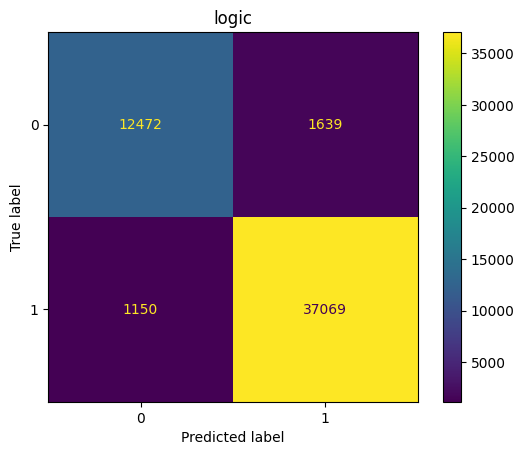

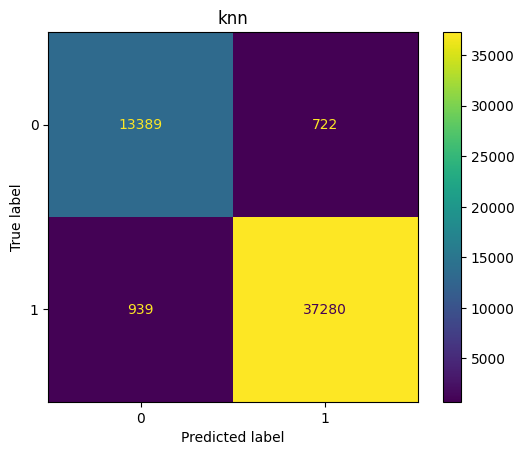

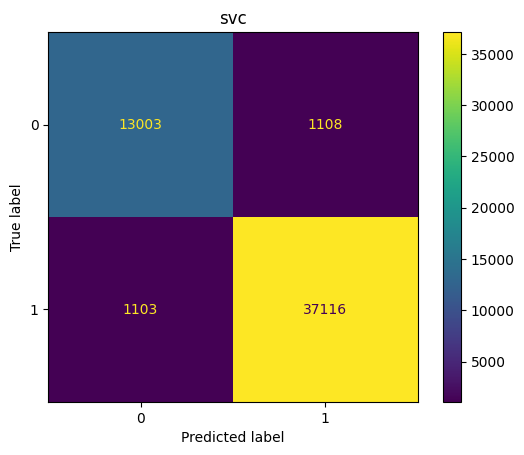

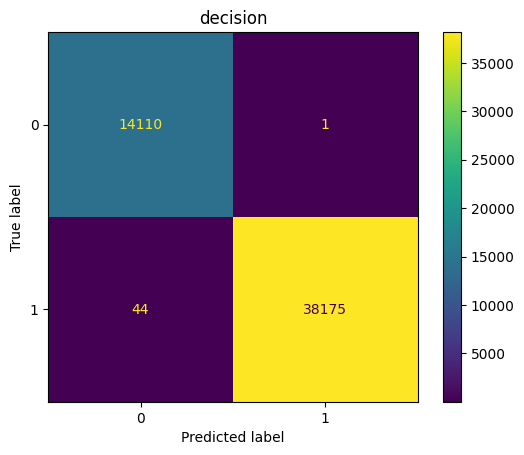

==================== Test ====================


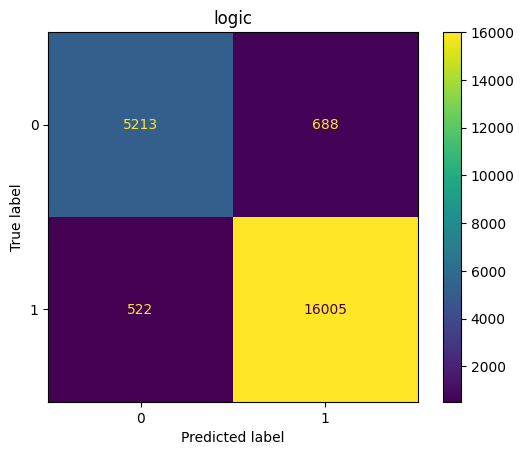

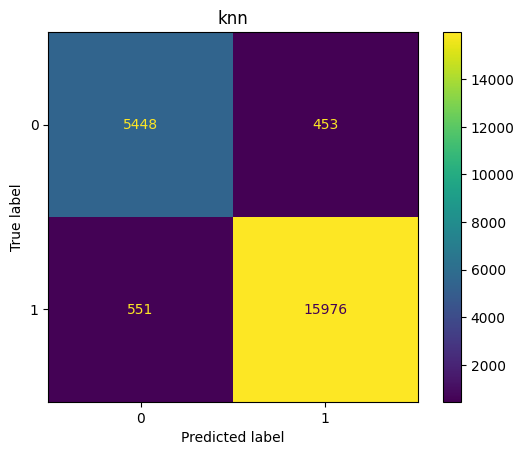

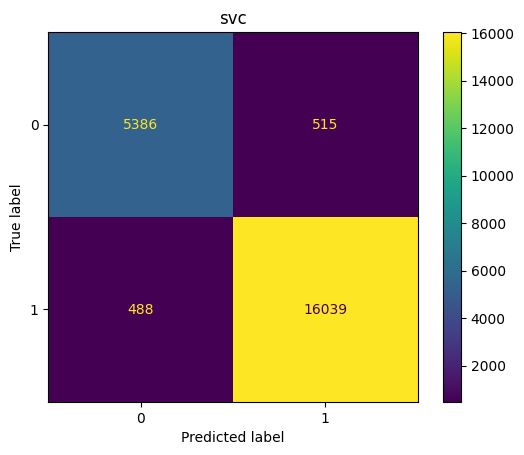

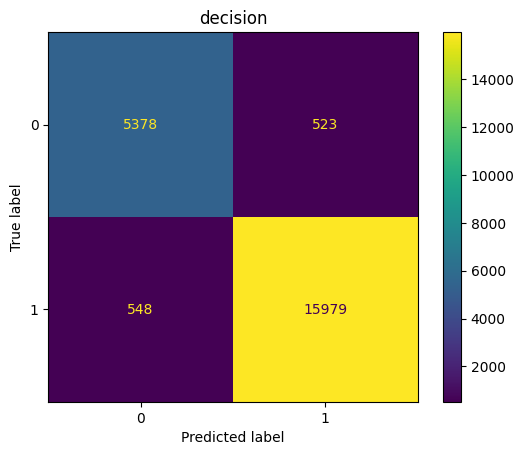

In [45]:
print('='*20,'Train','='*20)
conf_matrix_show(X_train,y_train,wot_model)
print('='*20,'Test','='*20)
conf_matrix_show(X_test,y_test,wot_model)
# print('='*20,'Real Data Test','='*20)
# conf_matrix_show(X,y,wot_model)

#### With Tunning

==================== Train ====================


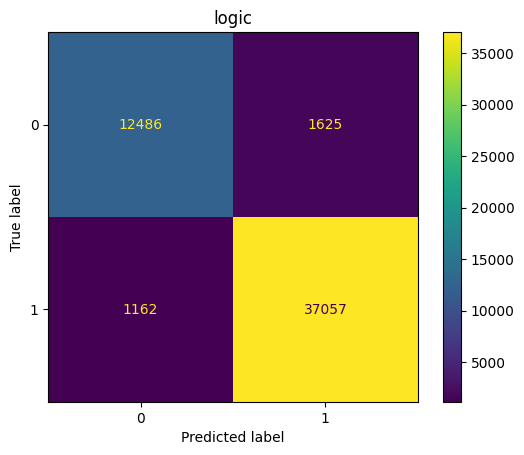

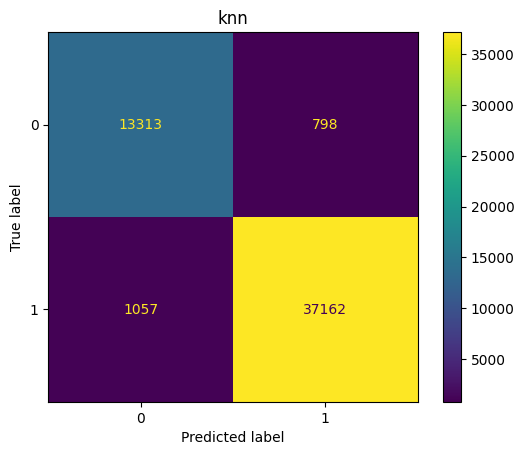

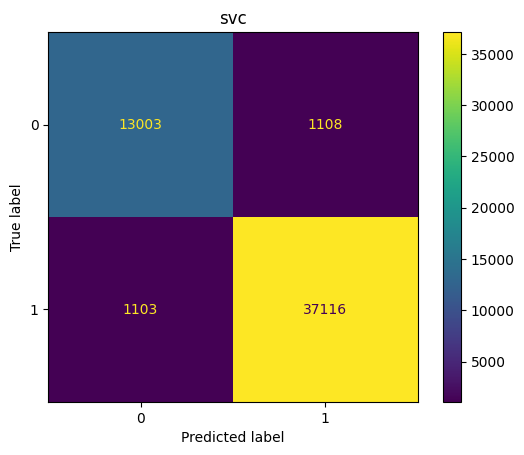

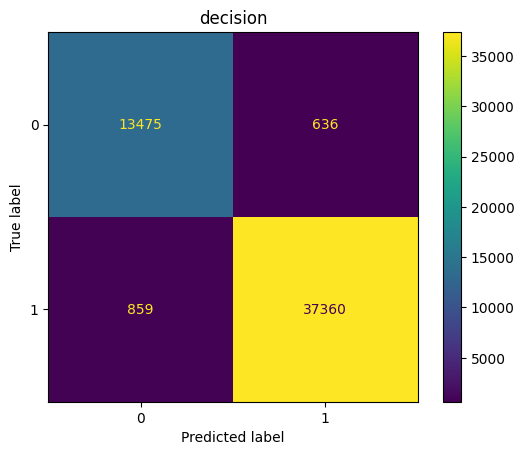

==================== Test ====================


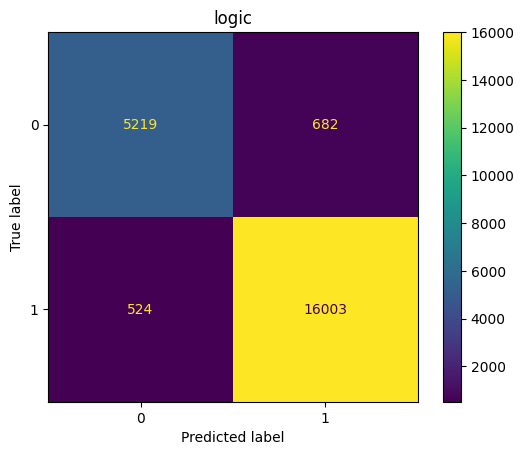

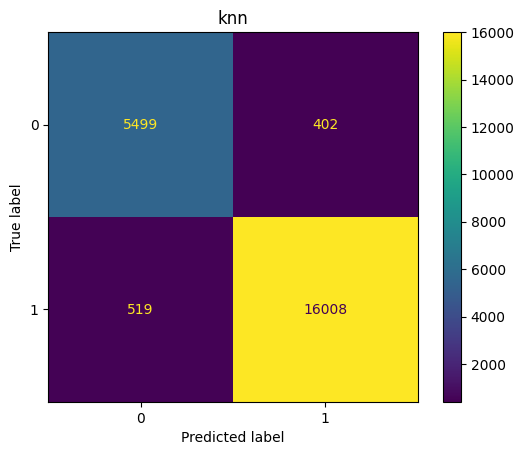

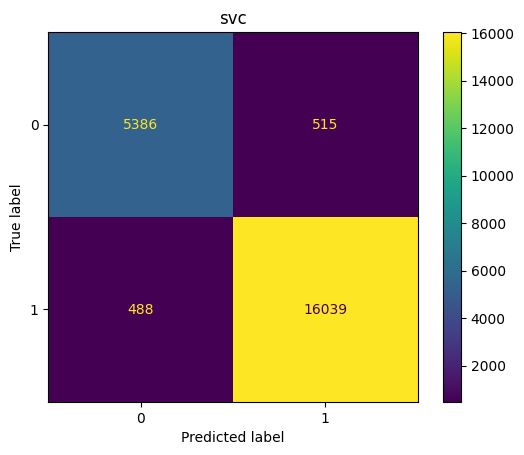

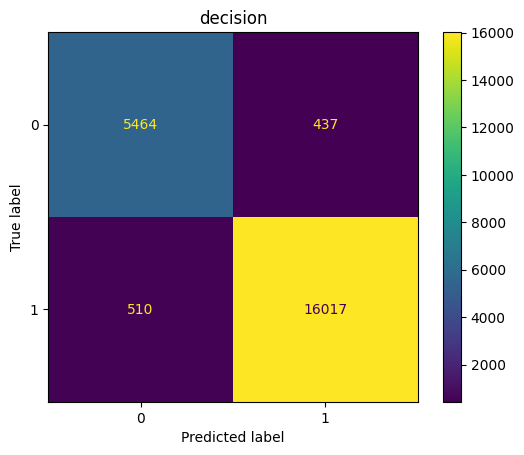

In [46]:
print('='*20,'Train','='*20)
conf_matrix_show(X_train,y_train,wt_model)
print('='*20,'Test','='*20)
conf_matrix_show(X_test,y_test,wt_model)
# print('='*20,'Real Data Test','='*20)
# conf_matrix_show(X,y,wt_model)

## Model Evaluation Conclusion

- In Train Test Percentage Evaluation, KNN after tunning are good because it have > 95% accuracy and highest f1-score
- In Confusion Matrix Evaluation, Decision Tree Classifier after tunning are good because it have smallest False Positive and True Negative and doesn't overfit unlike before Tunning
- Decision Tree after tunning are model that'll be saved because it has smallest False Positive and True Negative

# Model Saving

In [47]:
# Feature Saving
json.dump(feature,open('feature.json','w'))
# Model Saving
joblib.dump(wt_model['decision'],'model.pkl')

['model.pkl']

# Model Inference

In [48]:
model_test = joblib.load('model.pkl')

In [49]:
model_test.predict(X)

array([0., 1., 0., ..., 1., 0., 1.])

# Requirement Listing

In [52]:
import matplotlib
import sklearn
import feature_engine
req = f"""
      numpy=={np.__version__}
      pandas=={pd.__version__}
      matplotlib=={matplotlib.__version__}
      seaborn=={sns.__version__}
      joblib=={joblib.__version__}
      sklearn=={sklearn.__version__}
      feature-engine=={feature_engine.__version__}
      """
with open('requirements.txt','w') as file:
      file.write(req)
